In [4]:
import os
from os.path import abspath, expanduser
from typing import Any, Callable, List, Dict, Optional, Tuple, Union

import torch
from PIL import Image, ImageDraw

import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.datasets.utils import *
from torchvision.datasets.vision import VisionDataset

In [36]:
# https://pytorch.org/vision/0.12/_modules/torchvision/datasets/widerface.html

class WIDERFace(VisionDataset):
    """`WIDERFace <http://shuoyang1213.me/WIDERFACE/>`_ Dataset.

    Args:
        root (string): Root directory where images and annotations are downloaded to.
            Expects the following folder structure if download=False:

            .. code::

                <root>
                    └── widerface
                        ├── wider_face_split ('wider_face_split.zip' if compressed)
                        ├── WIDER_train ('WIDER_train.zip' if compressed)
                        ├── WIDER_val ('WIDER_val.zip' if compressed)
                        └── WIDER_test ('WIDER_test.zip' if compressed)
        split (string): The dataset split to use. One of {``train``, ``val``, ``test``}.
            Defaults to ``train``.
        transform (callable, optional): A function/transform that  takes in a PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """

    BASE_FOLDER = "widerface"
    FILE_LIST = [
        # File ID                             MD5 Hash                            Filename
        ("15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M", "3fedf70df600953d25982bcd13d91ba2", "WIDER_train.zip"),
        ("1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q", "dfa7d7e790efa35df3788964cf0bbaea", "WIDER_val.zip"),
        ("1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T", "e5d8f4248ed24c334bbd12f49c29dd40", "WIDER_test.zip"),
    ]
    ANNOTATIONS_FILE = (
        "http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip",
        "0e3767bcf0e326556d407bf5bff5d27c",
        "wider_face_split.zip",
    )


    def __init__(
        self,
        root: str,
        split: str = "train",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
        super().__init__(
            root=os.path.join(root, self.BASE_FOLDER), transform=transform, target_transform=target_transform
        )
        # check arguments
        self.split = verify_str_arg(split, "split", ("train", "val", "test"))

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError("Dataset not found or corrupted. You can use download=True to download and prepare it")

        self.img_info: List[Dict[str, Union[str, Dict[str, torch.Tensor]]]] = []
        if self.split in ("train", "val"):
            self.parse_train_val_annotations_file()
        else:
            self.parse_test_annotations_file()


    def __getitem__(self, index: int, image_as_tensor_or_PIL: bool = True) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
            image_as_tensor_or_PIL (boolean): if True, image will be read as torch Tensor, otherwise as PIL image

        Returns:
            tuple: (image, target) where target is a dict of annotations for all faces in the image.
            target=None for the test split.
        """

        # stay consistent with other datasets and return a PIL Image
        #img = Image.open(self.img_info[index]["img_path"])
        # instead, return as tensor, because draw_bounding_box uses tensor
        img = read_image(self.img_info[index]["img_path"])

        if self.transform is not None:
            img = self.transform(img)

        target = None if self.split == "test" else self.img_info[index]["annotations"]
        # convert bounding box format
        target['bbox'] = convert_WIDERFace_bbox_to_Pytorch_bbox(target['bbox'])

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


    def __len__(self) -> int:
        return len(self.img_info)

    
    def convert_WIDERFace_bbox_to_Pytorch_bbox(bbox):
        """
            Helper method that converts WIDERFace bounding box format to format used in Pytorch bounding box. Used in __getitem__ method
        
            Args:
                bbox: format of WIDERFace bounding box is array of size(N, 4) 
                    containing bounding box in format (x1, y1, w, h)

            Returns:
                Pytorch_bbox: we want to return bbox in a format that pytorch function draw_bounding_box uses.
                    That format is: Tensor of size (N, 4) containing bounding boxes in (xmin, ymin, xmax, ymax) format. 
                    Note that the boxes are absolute coordinates with respect to the image. 
                    In other words: 0 <= xmin < xmax < W and 0 <= ymin < ymax < H.
        """
        bbox[:, 2] = bbox[:, 0] + bbox[:, 2]
        bbox[:, 3] = bbox[:, 1] + bbox[:, 3]
        return bbox



    def extra_repr(self) -> str:
        lines = ["Split: {split}"]
        return "\n".join(lines).format(**self.__dict__)

    def parse_train_val_annotations_file(self) -> None:
        filename = "wider_face_train_bbx_gt.txt" if self.split == "train" else "wider_face_val_bbx_gt.txt"
        filepath = os.path.join(self.root, "wider_face_split", filename)

        with open(filepath) as f:
            lines = f.readlines()
            file_name_line, num_boxes_line, box_annotation_line = True, False, False
            num_boxes, box_counter = 0, 0
            labels = []
            for line in lines:
                line = line.rstrip()
                if file_name_line:
                    img_path = os.path.join(self.root, "WIDER_" + self.split, "images", line)
                    img_path = abspath(expanduser(img_path))
                    file_name_line = False
                    num_boxes_line = True
                elif num_boxes_line:
                    num_boxes = int(line)
                    num_boxes_line = False
                    box_annotation_line = True
                elif box_annotation_line:
                    box_counter += 1
                    line_split = line.split(" ")
                    line_values = [int(x) for x in line_split]
                    labels.append(line_values)
                    if box_counter >= num_boxes:
                        box_annotation_line = False
                        file_name_line = True
                        labels_tensor = torch.tensor(labels)
                        self.img_info.append(
                            {
                                "img_path": img_path,
                                "annotations": {
                                    "bbox": labels_tensor[:, 0:4],  # x, y, width, height
                                    "blur": labels_tensor[:, 4],
                                    "expression": labels_tensor[:, 5],
                                    "illumination": labels_tensor[:, 6],
                                    "occlusion": labels_tensor[:, 7],
                                    "pose": labels_tensor[:, 8],
                                    "invalid": labels_tensor[:, 9],
                                },
                            }
                        )
                        box_counter = 0
                        labels.clear()
                else:
                    raise RuntimeError(f"Error parsing annotation file {filepath}")

    def parse_test_annotations_file(self) -> None:
        filepath = os.path.join(self.root, "wider_face_split", "wider_face_test_filelist.txt")
        filepath = abspath(expanduser(filepath))
        with open(filepath) as f:
            lines = f.readlines()
            for line in lines:
                line = line.rstrip()
                img_path = os.path.join(self.root, "WIDER_test", "images", line)
                img_path = abspath(expanduser(img_path))
                self.img_info.append({"img_path": img_path})

    def _check_integrity(self) -> bool:
        # Allow original archive to be deleted (zip). Only need the extracted images
        all_files = self.FILE_LIST.copy()
        all_files.append(self.ANNOTATIONS_FILE)
        for (_, md5, filename) in all_files:
            file, ext = os.path.splitext(filename)
            extracted_dir = os.path.join(self.root, file)
            if not os.path.exists(extracted_dir):
                return False
        return True

    def download(self) -> None:
        if self._check_integrity():
            print("Files already downloaded and verified")
            return

        # download and extract image data
        for (file_id, md5, filename) in self.FILE_LIST:
            download_file_from_google_drive(file_id, self.root, filename, md5)
            filepath = os.path.join(self.root, filename)
            extract_archive(filepath)

        # download and extract annotation files
        download_and_extract_archive(
            url=self.ANNOTATIONS_FILE[0], download_root=self.root, md5=self.ANNOTATIONS_FILE[1]
        )


In [37]:
wider_face = WIDERFace('.')

image shape = (1024, 768)


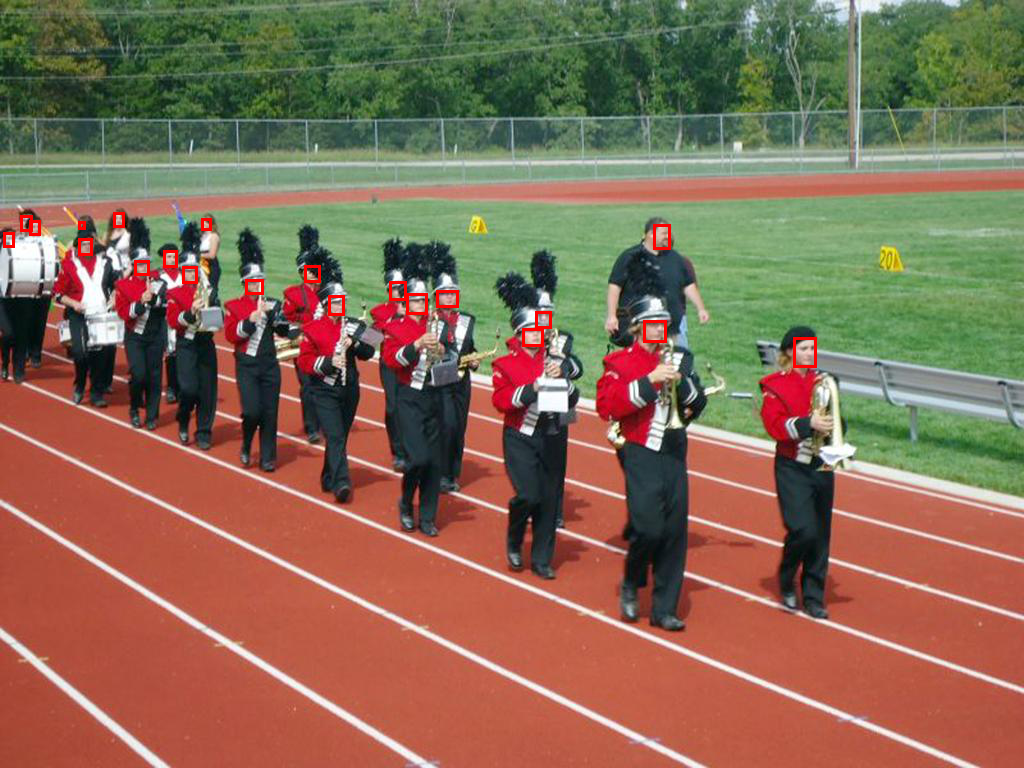

In [38]:
# https://www.tutorialspoint.com/how-to-draw-bounding-boxes-on-an-image-in-pytorch

# with tensor we provide shapes in [C,H,W] dimensions.

image, target = wider_face[2]
image = draw_bounding_boxes(image, target['bbox'], width=3, colors='red')
image = transforms.ToPILImage()(image)
print(f'image shape = {image.size}')
display(image)

In [ ]:

image = transforms.ToTensor()(image)
print(target['bbox'])
print(image.dtype)
draw_bounding_boxes(image.permute(0,1,2), boxes=target['bbox'], width=2)